<a href="https://colab.research.google.com/github/hhtt67678/ML_with_Pytorch/blob/main/04_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises.

## Exercise 1.
Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. More training data, with more examples of features for the model to learn.
2. Training for more epochs so the model has more time to learn the features in the dataset.
3. Modifying the parameters in the model itself, i.e. the number of hidden units, kernel and stride, number of layers, etc.

## Exercise 2. 

Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [1]:
import torch
from torchvision.datasets import ImageFolder
import pathlib
import os
import requests
import zipfile

In [2]:
# Download training data into a folder

data_path = pathlib.Path('data/')
image_path = data_path / 'food_image_data'

if image_path.is_dir():
  print(f'{image_path} exists, skipping download')
else:
  print(f'dir not found, creating...')
  image_path.mkdir(parents=True, exist_ok=True)

with open(image_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Response code: {request.status_code}')
  f.write(request.content)

dir not found, creating...
Response code: 200


In [3]:
# unzip using ZipFile

with zipfile.ZipFile(image_path/'pizza_steak_sushi.zip', 'r') as f:
  f.extractall(image_path)

In [4]:
# practice using os.walk

def walk_dir(directory):
  for a, b, c in os.walk(directory):
    print(f'Dir: {a} | Num subdirs: {len(b)} | Num files: {len(c)}')

walk_dir(data_path)

Dir: data | Num subdirs: 1 | Num files: 0
Dir: data/food_image_data | Num subdirs: 2 | Num files: 1
Dir: data/food_image_data/test | Num subdirs: 3 | Num files: 0
Dir: data/food_image_data/test/sushi | Num subdirs: 0 | Num files: 31
Dir: data/food_image_data/test/steak | Num subdirs: 0 | Num files: 19
Dir: data/food_image_data/test/pizza | Num subdirs: 0 | Num files: 25
Dir: data/food_image_data/train | Num subdirs: 3 | Num files: 0
Dir: data/food_image_data/train/sushi | Num subdirs: 0 | Num files: 72
Dir: data/food_image_data/train/steak | Num subdirs: 0 | Num files: 75
Dir: data/food_image_data/train/pizza | Num subdirs: 0 | Num files: 78


In [5]:
# create transforms for data

from torchvision import transforms

SIZE = (64, 64)
# SIZE = (128, 128)

transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()]
    )

transform_test = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor()
])

# create randomly transformed datasets for train/test

train_dataset = ImageFolder(root=image_path / 'train', transform=transform)
test_dataset = ImageFolder(root=image_path / 'test', transform=transform_test)

In [6]:
# create a dataloader

from torch.utils.data import DataLoader

num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=num_workers)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             num_workers=num_workers
                             )



In [7]:
# dataset has classes attribute and class_to_idx dict

# train_dataset.class_to_idx
idx_to_class = dict(zip(range(len(train_dataset.classes)), train_dataset.classes))

In [8]:
idx_to_class

{0: 'pizza', 1: 'steak', 2: 'sushi'}

In [9]:
train_dataset.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [10]:
# Rebuild TinyVGG model
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [11]:
# Instance class model

torch.manual_seed(10),
torch.cuda.manual_seed(10)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_dataset.classes))

In [12]:
# try:
#   import torchinfo
# except:
#   !pip install torchinfo
#   import torchinfo

# from torchinfo import summary
# summary(model_0, input_size=[1, 3, 128, 128])

In [13]:
# train/test functions

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # dataloader is iterable of tuples (batch, (X, y)) 
    # where batch is index (int) and X, y are data, target classes
    # self note: each X is a tensor batch [32, 1, 64, 64]
    X, y = X.to(device), y.to(device)

    #----------------------------
    # Model Training Phase
    # forward pass
    y_pred = model(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item() # .item() gets the number not tensor

    # optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # optimizer step
    optimizer.step()
    #-------------------------------
    # Accuracy Calculations
    # Since this is done in batches, the accuracy is calculated for each (X, y)
    # and added up to an average accuracy for the total batch.
    
    # convert predicted logits to probabilities, then argmax returns the predicted
    # class label.
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    # Right side takes the average accuracy for the batch, then adds to the
    # accumulated accuracy so far
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  
  # average the loss and training accuracy to get the average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

  

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      
      test_pred_logits = model(X)

      # accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # accumulate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
  
  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [14]:
# training function

# Create a train function to combine train_step, test_step

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5):
  
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    print(
        f'Epoch: {epoch+1}|'
        f'train_loss: {train_loss:.4f}|'
        f'train_acc: {train_acc:.4f}|'
        f'test_loss: {test_loss:.4f}|'
        f'test_acc: {test_acc:4f}|'
    )

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

In [15]:

# Loss Curve Plotting Function

import matplotlib.pyplot as plt

def plot_loss_curves(results):
  
  loss = results['train_loss']
  test_loss = results['test_loss']
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [16]:
# set loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)


In [17]:
results_dict = {}
from timeit import default_timer as timer

for EPOCHS in [3, 5, 20, 50]:
  torch.manual_seed(10)
  torch.cuda.manual_seed(10)
  model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)
  start_time = timer()
  results = train(model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=nn.CrossEntropyLoss(),
        epochs=EPOCHS)
  end_time = timer()
  train_time = end_time - start_time
  results_dict[EPOCHS] = {'results': results, 'train_time': train_time}

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1065|train_acc: 0.2812|test_loss: 1.1136|test_acc: 0.291667|
Epoch: 2|train_loss: 1.1025|train_acc: 0.2969|test_loss: 1.1504|test_acc: 0.197917|
Epoch: 3|train_loss: 1.0919|train_acc: 0.2969|test_loss: 1.1308|test_acc: 0.302083|


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1065|train_acc: 0.2812|test_loss: 1.1136|test_acc: 0.291667|
Epoch: 2|train_loss: 1.1024|train_acc: 0.3008|test_loss: 1.1500|test_acc: 0.197917|
Epoch: 3|train_loss: 1.0916|train_acc: 0.2969|test_loss: 1.1309|test_acc: 0.312500|
Epoch: 4|train_loss: 1.0788|train_acc: 0.5391|test_loss: 1.1194|test_acc: 0.302083|
Epoch: 5|train_loss: 1.1047|train_acc: 0.3516|test_loss: 1.0978|test_acc: 0.302083|


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1065|train_acc: 0.2812|test_loss: 1.1136|test_acc: 0.291667|
Epoch: 2|train_loss: 1.1024|train_acc: 0.3008|test_loss: 1.1501|test_acc: 0.197917|
Epoch: 3|train_loss: 1.0916|train_acc: 0.2969|test_loss: 1.1309|test_acc: 0.312500|
Epoch: 4|train_loss: 1.0787|train_acc: 0.5391|test_loss: 1.1196|test_acc: 0.291667|
Epoch: 5|train_loss: 1.1049|train_acc: 0.3516|test_loss: 1.0981|test_acc: 0.312500|
Epoch: 6|train_loss: 1.0210|train_acc: 0.4961|test_loss: 0.9591|test_acc: 0.573864|
Epoch: 7|train_loss: 1.0304|train_acc: 0.3906|test_loss: 1.1439|test_acc: 0.332386|
Epoch: 8|train_loss: 1.0589|train_acc: 0.5156|test_loss: 1.1884|test_acc: 0.301136|
Epoch: 9|train_loss: 1.0153|train_acc: 0.4570|test_loss: 1.1364|test_acc: 0.341856|
Epoch: 10|train_loss: 1.0493|train_acc: 0.3984|test_loss: 1.0961|test_acc: 0.362689|
Epoch: 11|train_loss: 1.0432|train_acc: 0.4570|test_loss: 1.0456|test_acc: 0.362689|
Epoch: 12|train_loss: 1.0132|train_acc: 0.4375|test_loss: 0.9504|test_acc:

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1065|train_acc: 0.2812|test_loss: 1.1136|test_acc: 0.291667|
Epoch: 2|train_loss: 1.1024|train_acc: 0.3008|test_loss: 1.1500|test_acc: 0.197917|
Epoch: 3|train_loss: 1.0916|train_acc: 0.2969|test_loss: 1.1309|test_acc: 0.312500|
Epoch: 4|train_loss: 1.0788|train_acc: 0.5391|test_loss: 1.1194|test_acc: 0.302083|
Epoch: 5|train_loss: 1.1046|train_acc: 0.3516|test_loss: 1.0972|test_acc: 0.312500|
Epoch: 6|train_loss: 1.0202|train_acc: 0.5000|test_loss: 0.9598|test_acc: 0.573864|
Epoch: 7|train_loss: 1.0284|train_acc: 0.4023|test_loss: 1.1510|test_acc: 0.332386|
Epoch: 8|train_loss: 1.0603|train_acc: 0.5195|test_loss: 1.1854|test_acc: 0.301136|
Epoch: 9|train_loss: 1.0132|train_acc: 0.4648|test_loss: 1.1330|test_acc: 0.361742|
Epoch: 10|train_loss: 1.0520|train_acc: 0.3984|test_loss: 1.0918|test_acc: 0.424242|
Epoch: 11|train_loss: 1.0403|train_acc: 0.4609|test_loss: 1.0429|test_acc: 0.362689|
Epoch: 12|train_loss: 1.0158|train_acc: 0.4414|test_loss: 0.9551|test_acc:

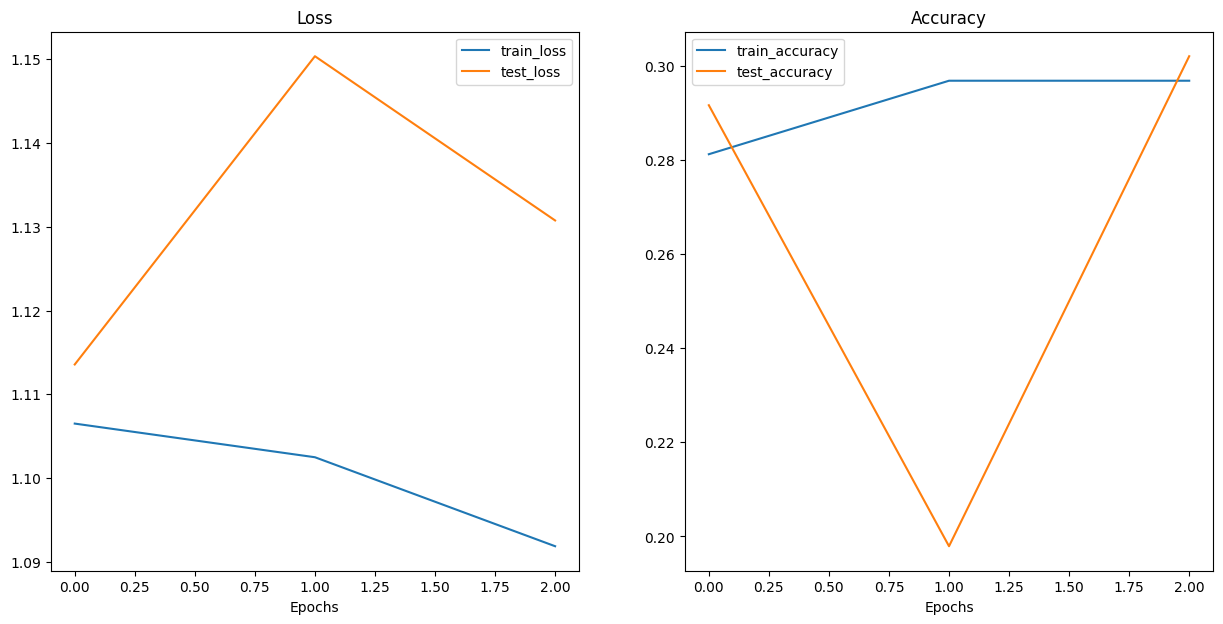

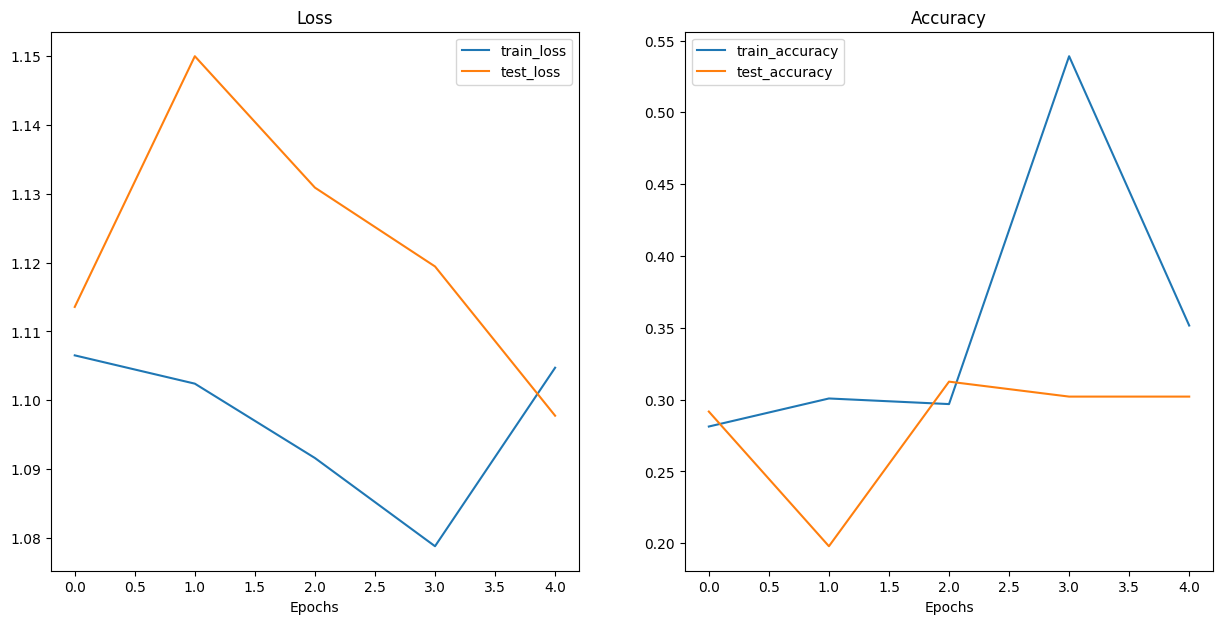

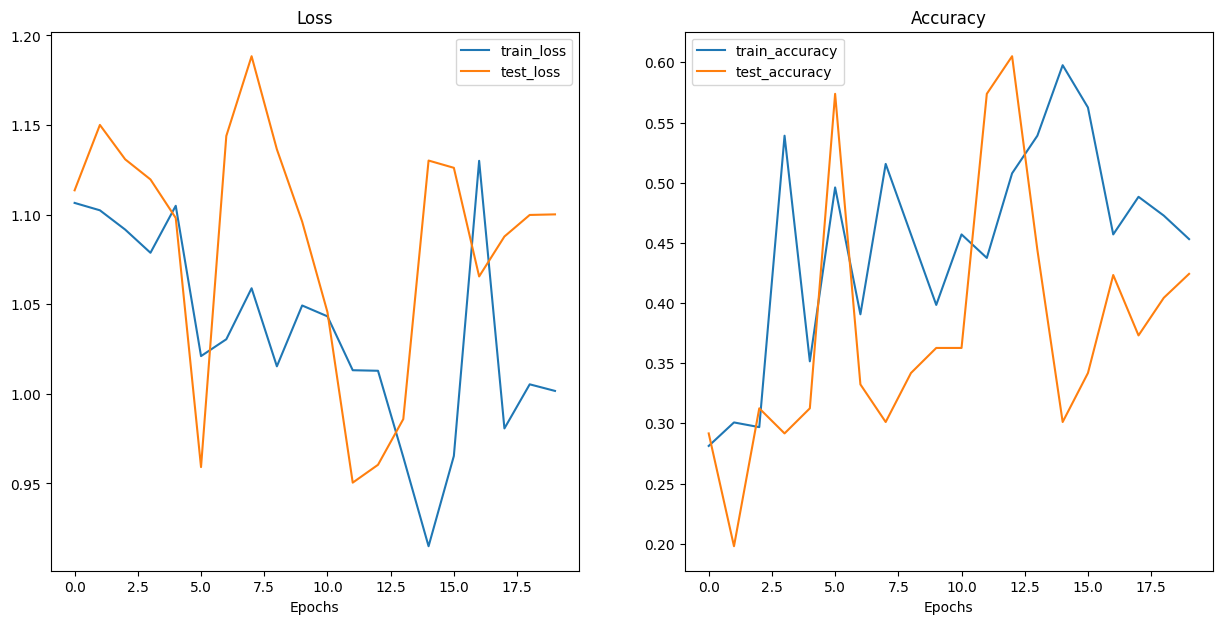

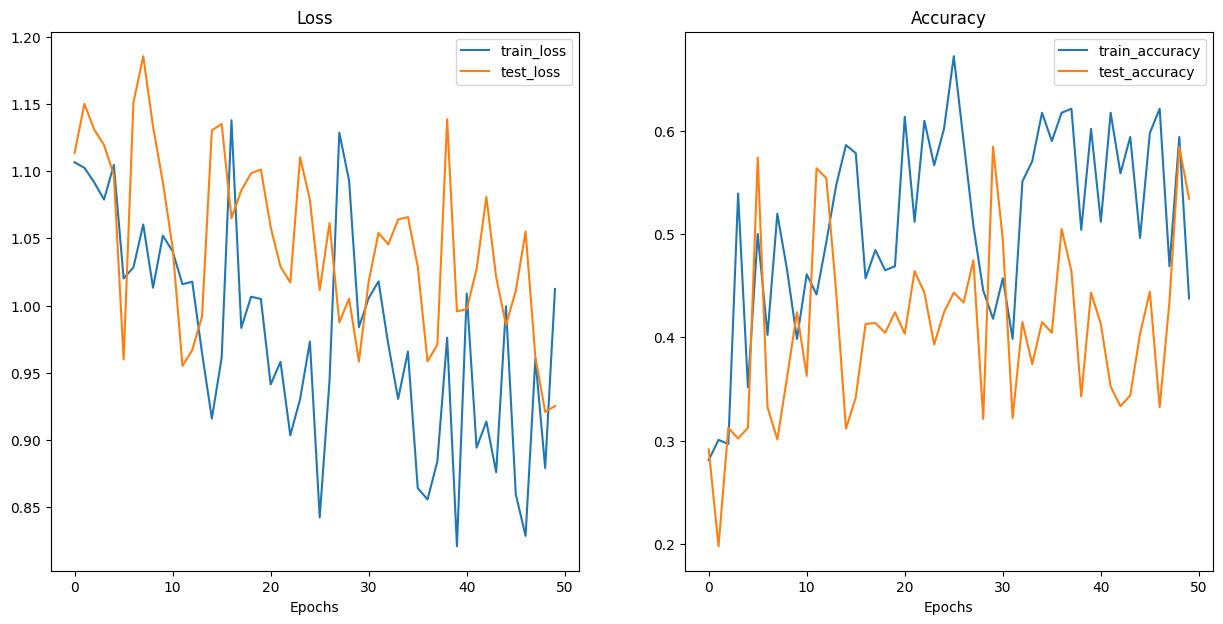

In [18]:
for EPOCHS in [3, 5, 20, 50]:
  plot_loss_curves(results_dict[EPOCHS]['results'])

Doesn't look good, why all the volatility?

## Exercise 6. Since all the previous gives some underperforming results, try doing a new model with more hidden units and training for 20 epochs.

In [19]:
torch.cuda.manual_seed(10)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_dataset.classes)).to(device)

results = train(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=torch.optim.Adam(params=model_1.parameters(), lr=0.001),
      loss_fn=nn.CrossEntropyLoss(),
      epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1088|train_acc: 0.2930|test_loss: 1.1042|test_acc: 0.197917|
Epoch: 2|train_loss: 1.0883|train_acc: 0.4102|test_loss: 1.1104|test_acc: 0.260417|
Epoch: 3|train_loss: 1.1128|train_acc: 0.3047|test_loss: 1.1156|test_acc: 0.260417|
Epoch: 4|train_loss: 1.0800|train_acc: 0.4297|test_loss: 1.0790|test_acc: 0.281250|
Epoch: 5|train_loss: 1.0769|train_acc: 0.3594|test_loss: 1.0600|test_acc: 0.260417|
Epoch: 6|train_loss: 1.0230|train_acc: 0.5508|test_loss: 1.0356|test_acc: 0.564394|
Epoch: 7|train_loss: 1.0924|train_acc: 0.3906|test_loss: 1.0744|test_acc: 0.414773|
Epoch: 8|train_loss: 0.9337|train_acc: 0.6016|test_loss: 1.0983|test_acc: 0.404356|
Epoch: 9|train_loss: 0.9719|train_acc: 0.5859|test_loss: 1.1177|test_acc: 0.352273|
Epoch: 10|train_loss: 1.0275|train_acc: 0.4570|test_loss: 0.9834|test_acc: 0.546402|
Epoch: 11|train_loss: 0.8503|train_acc: 0.6016|test_loss: 1.0361|test_acc: 0.444129|
Epoch: 12|train_loss: 0.8948|train_acc: 0.5820|test_loss: 0.9643|test_acc:

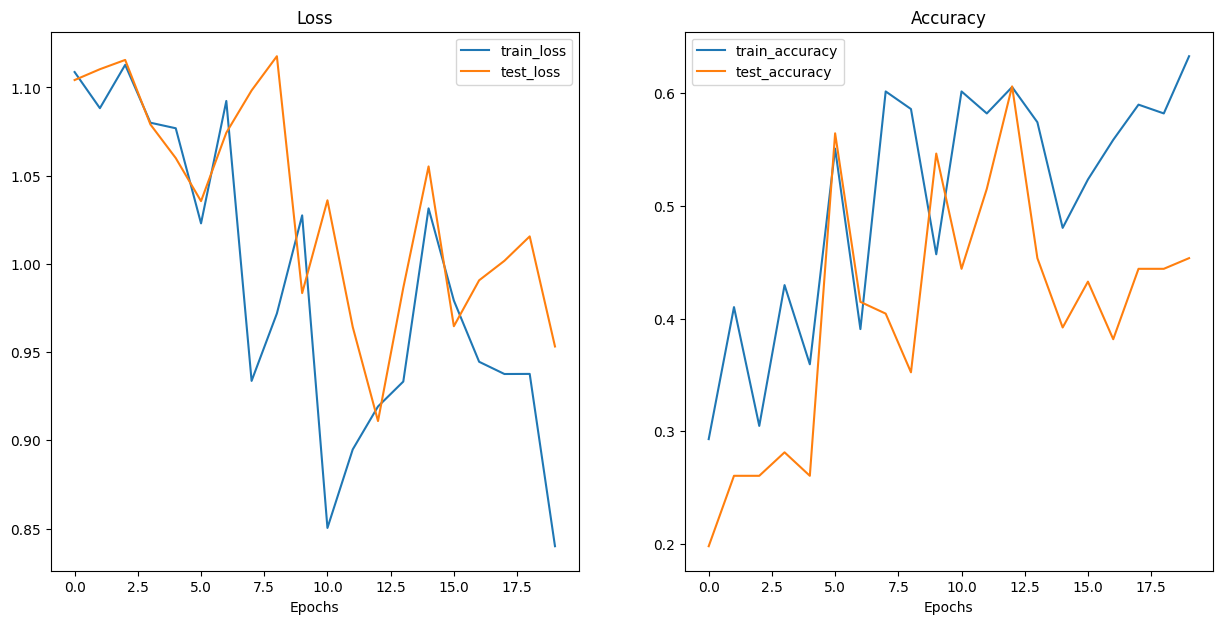

In [20]:
plot_loss_curves(results)

## Exercise 7. Get the larger dataset and try training on this one and plot performance.

In [21]:
# make a download function
def get_data(path: str,
             data_folder: str,
             zip_filename: str,
             url: str):
  
  '''
  Download the zipped dataset from a given url.
  '''

  data_path = pathlib.Path(path)
  image_path = data_path / data_folder

  #check if path already exists
  if  image_path.is_dir():
    print(f'{image_path} already exists, skipping creation.')
  else:
    print(f'Creating{image_path}...')
    image_path.mkdir(parents=True, exist_ok=True)

  # Download data
  with open(image_path / zip_filename, 'wb') as f:
    request = requests.get(url)
    print(f'Response code: {request.status_code}')
    f.write(request.content)

  # Unzip data
  with zipfile.ZipFile(image_path/ zip_filename, 'r') as f:
    print(f'unzipping file...')
    f.extractall(image_path)
  
  # print results
  for a, b, c in os.walk(image_path):
    print(f'Data Directory Structure\nDir: {a} | Num subdirs: {len(b)} | Num files: {len(c)}')

In [22]:
get_data(path='data/', 
         data_folder='food_data_2', 
         zip_filename='pizza_steak_sushi_20_percent.zip',
         url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')

Creatingdata/food_data_2...
Response code: 200
unzipping file...
Data Directory Structure
Dir: data/food_data_2 | Num subdirs: 2 | Num files: 1
Data Directory Structure
Dir: data/food_data_2/test | Num subdirs: 3 | Num files: 0
Data Directory Structure
Dir: data/food_data_2/test/sushi | Num subdirs: 0 | Num files: 46
Data Directory Structure
Dir: data/food_data_2/test/steak | Num subdirs: 0 | Num files: 58
Data Directory Structure
Dir: data/food_data_2/test/pizza | Num subdirs: 0 | Num files: 46
Data Directory Structure
Dir: data/food_data_2/train | Num subdirs: 3 | Num files: 0
Data Directory Structure
Dir: data/food_data_2/train/sushi | Num subdirs: 0 | Num files: 150
Data Directory Structure
Dir: data/food_data_2/train/steak | Num subdirs: 0 | Num files: 146
Data Directory Structure
Dir: data/food_data_2/train/pizza | Num subdirs: 0 | Num files: 154


In [23]:
data_path = pathlib.Path('data/')
image_path = data_path / 'food_data_2'

large_train_dataset = ImageFolder(image_path / 'train', transform=transform)

large_test_dataset = ImageFolder(image_path / 'test', transform=transform_test)

In [24]:
large_train_dataloader = DataLoader(dataset=large_train_dataset,
                                    batch_size=32,
                                    shuffle=True,
                                    num_workers=num_workers)

large_test_dataloader = DataLoader(dataset=large_test_dataset,
                                   batch_size=32,
                                   num_workers=num_workers)

In [25]:
large_classes = large_train_dataset.classes
large_classes

['pizza', 'steak', 'sushi']

In [26]:
torch.cuda.manual_seed(10)

model_2 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(large_train_dataset.classes)).to(device)

start_time = timer()

results = train(model=model_2,
      train_dataloader=large_train_dataloader,
      test_dataloader=large_test_dataloader,
      optimizer=torch.optim.Adam(params=model_2.parameters(), lr=0.001),
      loss_fn=nn.CrossEntropyLoss(),
      epochs=20)

end_time = timer()

print(f'Total training time: {end_time - start_time}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1|train_loss: 1.1051|train_acc: 0.3292|test_loss: 1.0941|test_acc: 0.287500|
Epoch: 2|train_loss: 1.0956|train_acc: 0.3396|test_loss: 1.0377|test_acc: 0.467045|
Epoch: 3|train_loss: 1.0420|train_acc: 0.4750|test_loss: 0.9622|test_acc: 0.537500|
Epoch: 4|train_loss: 1.0339|train_acc: 0.4000|test_loss: 0.9608|test_acc: 0.525568|
Epoch: 5|train_loss: 0.9833|train_acc: 0.4938|test_loss: 0.9000|test_acc: 0.589205|
Epoch: 6|train_loss: 0.9820|train_acc: 0.4875|test_loss: 0.8943|test_acc: 0.610795|
Epoch: 7|train_loss: 0.9915|train_acc: 0.4917|test_loss: 0.9594|test_acc: 0.500568|
Epoch: 8|train_loss: 1.0167|train_acc: 0.5104|test_loss: 0.9525|test_acc: 0.521023|
Epoch: 9|train_loss: 0.9114|train_acc: 0.5729|test_loss: 0.9079|test_acc: 0.550000|
Epoch: 10|train_loss: 0.9674|train_acc: 0.4750|test_loss: 0.8844|test_acc: 0.613636|
Epoch: 11|train_loss: 0.9388|train_acc: 0.5333|test_loss: 0.8899|test_acc: 0.603977|
Epoch: 12|train_loss: 0.9255|train_acc: 0.5312|test_loss: 0.8686|test_acc:

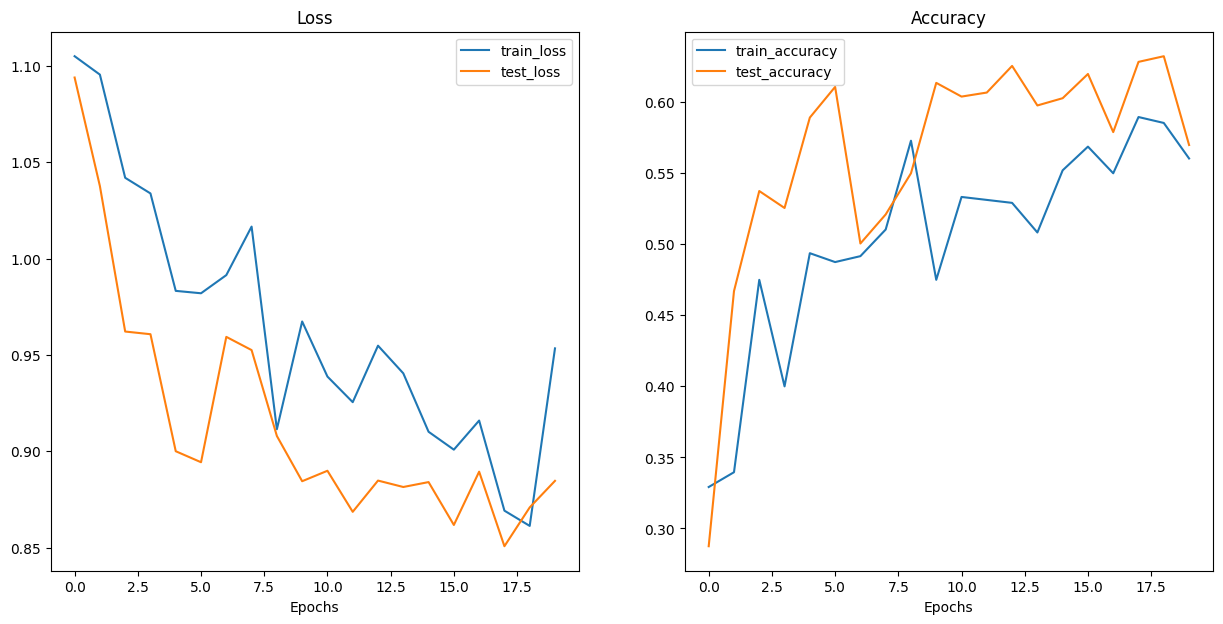

In [27]:
plot_loss_curves(results)

## Exercise 8. Use newly trained model to classify one of my own images.

In [31]:
import torchvision

custom_path = pathlib.Path('data/test_image.jpg')

custom_image_uint8 = torchvision.io.read_image(str(custom_path))

In [32]:
custom_image_uint8 = custom_image_uint8/ 255

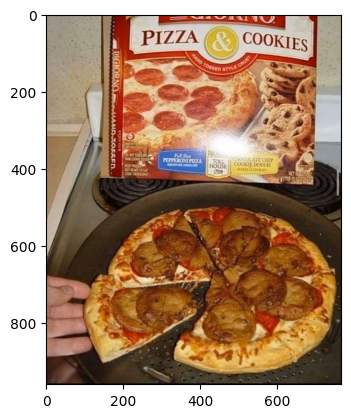

In [33]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [34]:
# transform image

custom_transform = transforms.Compose([transforms.Resize(SIZE)])

In [35]:
custom_image_transformed = custom_transform(custom_image_uint8)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


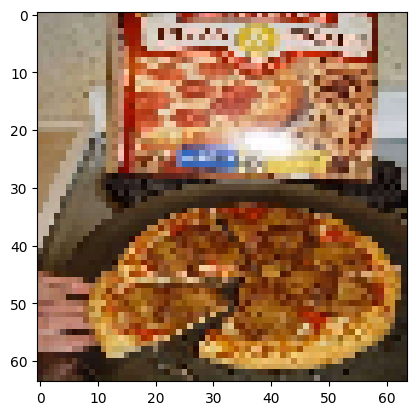

In [36]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [40]:
model_2.eval()
with torch.inference_mode():
  y = model_2(custom_image_transformed.unsqueeze(dim=0).to(device)).to(device)

In [41]:
pred_probs = torch.softmax(y, dim=1)
pred_label = pred_probs.squeeze(dim=0).argmax(dim=0)
prediction = large_classes[pred_label.item()]

In [42]:
prediction 

'steak'

In [43]:
!git version

git version 2.25.1


## Git notes

* `Clone`: Bring a Repository hosted elsewhere (e.g. Github) into a folder on the local machine.
* `add` : Track files and changes in Git
* `Commit`: save files in git.
* `push`: upload all git commits to remote repo, e.g. github
* `pull`: download changes from remote repo to your local machine, the opposite of push.

In [47]:
!git clone git@github.com:hhtt67678/ML_with_Pytorch.git

Cloning into 'ML_with_Pytorch'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
